In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
'Libraries imported!'

'Libraries imported!'

In [2]:
data = pd.read_csv('churn_data_simple.csv')
'DataFrame created!'

'DataFrame created!'

In [3]:
data.head()

,Unnamed: 0,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,...,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,days_since_last_transaction,doy_lst_tran,woy_lst_tran,moy_lst_tran,dow_lst_tran
0,0,1,2101,66,1,0.0,3,187.0,2,755,...,0.20,0.20,1458.71,1458.71,0,623,141.0,21.0,5.0,1.0
1,1,2,2348,35,1,0.0,3,1020.0,2,3214,...,5486.27,100.56,6496.78,8787.61,0,459,305.0,44.0,11.0,4.0
2,3,5,2329,90,1,0.0,3,1020.0,2,582,...,0.47,2143.33,2291.91,1669.79,1,546,218.0,32.0,8.0,1.0
3,4,6,1579,42,1,2.0,3,1494.0,3,388,...,588.62,1538.06,1157.15,1677.16,1,457,307.0,44.0,11.0,6.0
4,5,7,1923,42,0,0.0,3,1096.0,2,1666,...,857.50,286.07,15719.44,15349.75,0,459,305.0,44.0,11.0,4.0


## Checking if the dataset is balanced or not!

In [4]:
data.churn.value_counts(normalize=True)

0    0.802814
1    0.197186
Name: churn, dtype: float64

* Hence, the dataset is imbalanced!

## Separating dependent and independent variables

In [5]:
X = data.drop(columns=['churn','Unnamed: 0','customer_id'])
Y = data['churn']

## Scaling the dataset

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

## Splitting the dataset

In [7]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(scaled_X, Y, train_size = 0.80, random_state=42)
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((20127, 23), (5032, 23), (20127,), (5032,))

## Model Building, Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier as RFC
forest = RFC()
forest.fit(X_train,y_train)

RandomForestClassifier()

**Checking the default values of hyperparameter**

In [9]:
forest.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Checking the performance of the model

In [10]:
from sklearn.metrics import classification_report
predicted_values = forest.predict(X_train)
print(classification_report(y_train,predicted_values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16169
           1       1.00      1.00      1.00      3958

    accuracy                           1.00     20127
   macro avg       1.00      1.00      1.00     20127
weighted avg       1.00      1.00      1.00     20127



In [11]:
predicted_values = forest.predict(X_test)
print(classification_report(y_test,predicted_values))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4029
           1       0.71      0.43      0.53      1003

    accuracy                           0.85      5032
   macro avg       0.79      0.69      0.72      5032
weighted avg       0.84      0.85      0.84      5032



* Obviously, our model overfits!

Now to decide a suitable value for hyperparameter *n_estimators* and *max_samples*, we need to compare the *f1_score* at different hyperparameter values. Then, we'll decide the best one!

In [15]:
from sklearn.metrics import f1_score
def calc_score(model, x1, y1, x2, y2):
    '''
    This takes the model and the training and test dataset
    returns the corresponding f1_score
    '''

    model.fit(x1,y1)

    predict = model.predict(x1)
    f1 = f1_score(y1, predict)

    predict = model.predict(x2)
    f2 = f1_score(y2, predict)

    return f1, f2

In [18]:
def effect(train_score, test_score, x_axis, title):
    '''
    It plots the f1_score of training and test dataset at different
    values of hyperparameter for comparative analysis
    '''
    plt.figure(figsize = (7,4), dpi = 120)
    plt.plot(x_axis, train_score, color = 'red', label = 'train_Score')
    plt.plot(x_axis, test_score, color = 'blue', label = 'test_Score')
    plt.title(title)
    plt.legend()
    plt.xlabel("parameter_value")
    plt.ylabel("f1 score")
    plt.show()
 

**n_estimators**

In [19]:
estimators = [i for i in range(1,600,10)]
train = []
test = []

for i in estimators:
    model = RFC(class_weight = 'balanced_subsample',
              n_estimators = i,
              n_jobs = -1,
              random_state = 101)
    f1, f2 = calc_score(model, X_train, y_train, X_test, y_test)
    train.append(f1)
    test.append(f2)

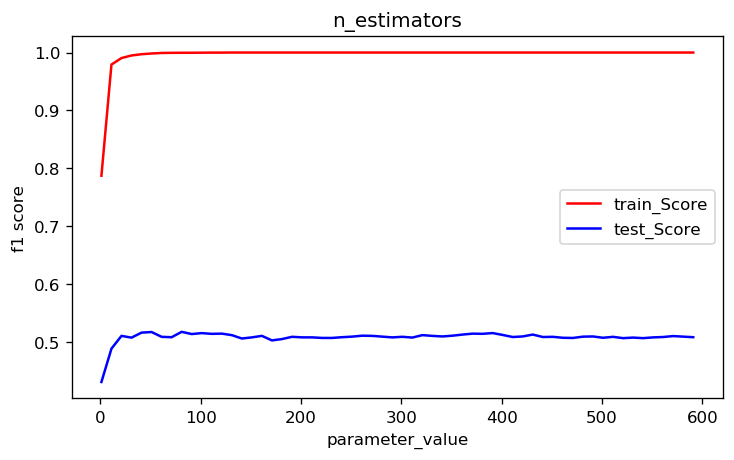

In [20]:
effect(train,test,range(1,600,10),'n_estimators')

In [21]:
diff = [i-j for i,j in zip(train,test)]
n_estimators_df = pd.DataFrame({'n_estimators':estimators,
                                'Train_Score':train,
                                'Test_Score':test,
                                'Difference':diff})
n_estimators_df.head(10)

,n_estimators,Train_Score,Test_Score,Difference
0,1,0.787146,0.430754,0.356392
1,11,0.979241,0.488357,0.490884
2,21,0.990450,0.510450,0.480000
3,31,0.994924,0.507367,0.487557
4,41,0.997087,0.516046,0.481041
5,51,0.998355,0.517086,0.481269
6,61,0.999241,0.508783,0.490458
7,71,0.999494,0.508122,0.491372
8,81,0.999621,0.517419,0.482202
9,91,0.999621,0.513583,0.486037


* Hence, the forest works comparatively good at n_estimators = 51

**max_samples**

In [22]:
maxsamples = [i/1000 for i in range(1,1000)]
train = []
test = []

for i in maxsamples:  
  model = RFC(class_weight = 'balanced_subsample', n_estimators = 51,
              n_jobs = -1, random_state = 101, max_samples = i)
  f1, f2 = calc_score(model, X_train, y_train, X_test, y_test)
  train.append(f1)
  test.append(f2)

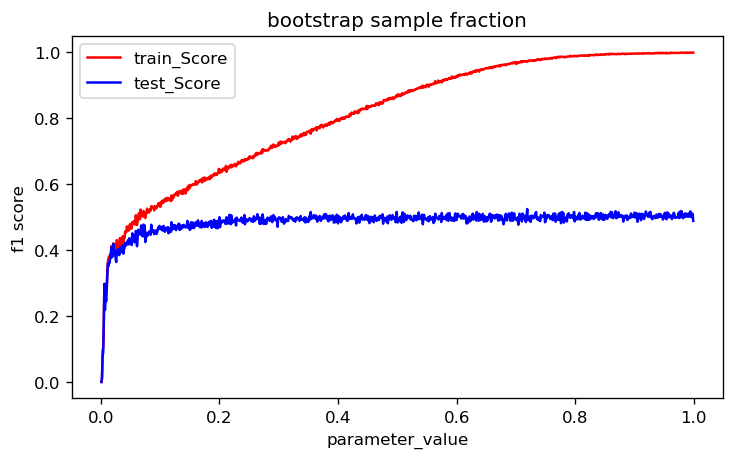

In [23]:
effect( train, test, maxsamples , 'bootstrap sample fraction')

In [ ]:
diff = [i-j for i,j in zip(train,test)]
max_samples_df = pd.DataFrame({'max_samples':maxsamples,
                                'Train_Score':train,
                                'Test_Score':test,
                                'Difference':diff})


In [26]:
max_samples_df.iloc[40:50,:]

,max_samples,Train_Score,Test_Score,Difference
40,0.041,0.456222,0.420827,0.035395
41,0.042,0.455984,0.414530,0.041454
42,0.043,0.454167,0.413990,0.040177
43,0.044,0.471715,0.423944,0.047771
44,0.045,0.462963,0.423430,0.039533
45,0.046,0.466702,0.430152,0.036550
46,0.047,0.458603,0.417256,0.041347
47,0.048,0.463042,0.435933,0.027109
48,0.049,0.477992,0.425532,0.052460
49,0.050,0.464809,0.431095,0.033713


* Hence, model works comparatively better at max_samples = 0.050

**max_features**

In [27]:
maxfeatures = range(1,X.shape[1])
train = []
test = []

for i in maxfeatures:  
    model = RFC(class_weight = 'balanced_subsample', n_estimators = 51, max_samples=0.5,
              n_jobs = -1, random_state = 101, max_features = i)
    f1, f2 = calc_score(model, X_train, y_train, X_test, y_test)
    train.append(f1)
    test.append(f2)

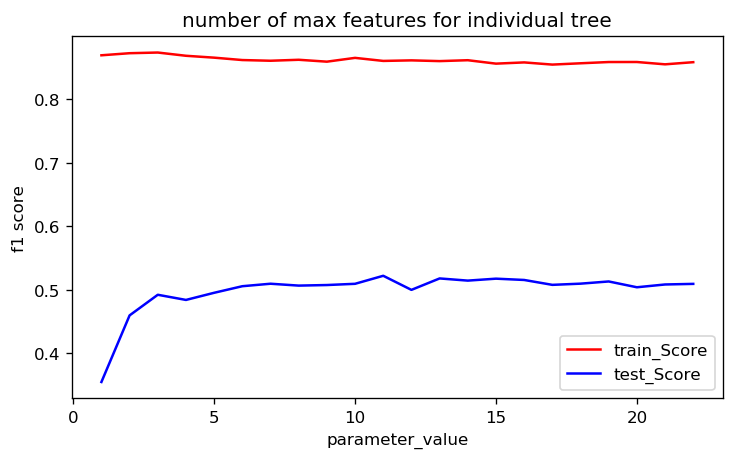

In [28]:
effect( train, test, maxfeatures , 'number of max features for individual tree')

In [32]:
diff = [i-j for i,j in zip(train,test)]
max_features_df = pd.DataFrame({'max_features':maxfeatures,
                                'Train_Score':train,
                                'Test_Score':test,
                                'Difference':diff})
max_features_df.iloc[5:20]

,max_features,Train_Score,Test_Score,Difference
5,6,0.861347,0.505438,0.355909
6,7,0.860248,0.509349,0.350900
7,8,0.861777,0.506394,0.355383
8,9,0.858799,0.507292,0.351506
9,10,0.864774,0.509230,0.355544
10,11,0.859966,0.521848,0.338118
11,12,0.860845,0.499681,0.361165
12,13,0.859679,0.517677,0.342002
13,14,0.861084,0.514250,0.346834
14,15,0.855693,0.517306,0.338387


* Hence, at max_features = 15, the model works comparatively well.

**max_depth**

In [41]:
maxdepth = [int(x) for x in np.linspace(5,500,num=100)]

train = []
test = []
for i in maxdepth:
    model = RFC(class_weight='balanced_subsample', n_estimators=51,
                n_jobs=-1, max_depth=i, random_state=101)
    f1,f2 = calc_score(model,X_train,y_train,X_test,y_test)
    train.append(f1)
    test.append(f2)

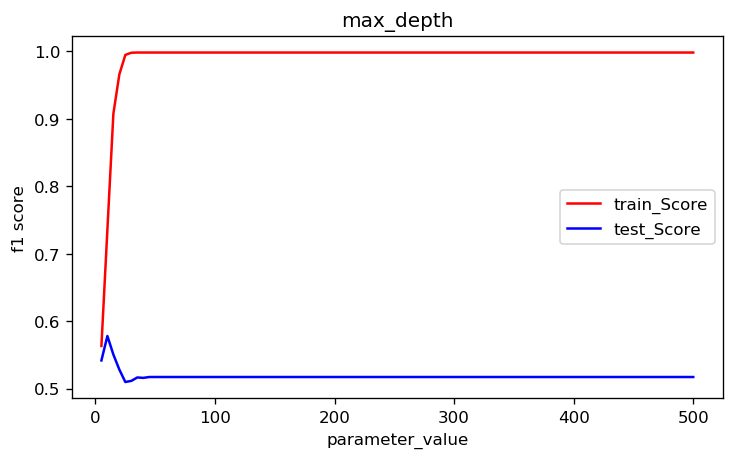

In [42]:
effect(train,test,maxdepth,'max_depth')

In [44]:
diff = [i-j for i,j in zip(train,test)]
max_depth_df = pd.DataFrame({'max_depth':maxdepth,
                                'Train_Score':train,
                                'Test_Score':test,
                                'Difference':diff})
max_depth_df.iloc[:20]

,max_depth,Train_Score,Test_Score,Difference
0,5,0.563131,0.541683,0.021447
1,10,0.735835,0.577885,0.157951
2,15,0.907653,0.550383,0.357270
3,20,0.966075,0.528040,0.438035
4,25,0.994794,0.509702,0.485091
5,30,0.998102,0.511327,0.486775
6,35,0.998355,0.516420,0.481935
7,40,0.998355,0.515796,0.482559
8,45,0.998355,0.517086,0.481269
9,50,0.998355,0.517086,0.481269


* Hence, max_depth = 10, the model works comparatively better.

Hence, the above comparative analysis has given us the approximate values of different hyperparameter at which the model works best. To reduce the time for RandomSearchCV we'll use these values to define the centre of our searching!

Now to create a good model we'll try **adjusting the following set of hyperparameters:**
* n_estimators
* max_features
* max_depth
* min_samples_split
* min_samples_leaf
* bootstrap

## Random Hyperparameter Grid
To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:


In [46]:
len(X.columns)

23

In [58]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=45,stop=60,num=10)]
max_features = [4,8,12,16]
max_samples = [float(x) for x in np.linspace(0.04,0.4,num=50)]
max_depth = [int(x) for x in np.linspace(5,20,num=5)]
max_depth.append(None)
min_samples_split=[int(x) for x in np.linspace(2,500,15)]
min_samples_leaf = [int(x) for x in np.linspace(1,500,20)]
bootstrap = [True,False]

random_grid = {'n_estimators':n_estimators,
               'max_samples':max_samples,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap}
from pprint import pprint
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 8, 12, 16, 20, None],
 'max_features': [4, 8, 12, 16],
 'max_samples': [0.04,
                 0.0473469387755102,
                 0.05469387755102041,
                 0.062040816326530614,
                 0.06938775510204082,
                 0.07673469387755102,
                 0.08408163265306123,
                 0.09142857142857144,
                 0.09877551020408164,
                 0.10612244897959183,
                 0.11346938775510204,
                 0.12081632653061225,
                 0.12816326530612246,
                 0.13551020408163267,
                 0.14285714285714288,
                 0.15020408163265306,
                 0.15755102040816327,
                 0.16489795918367348,
                 0.17224489795918368,
                 0.1795918367346939,
                 0.1869387755102041,
                 0.1942857142857143,
                 0.20163265306122452,
                 0.2089795918367347,
     

* Altogether, there are 10 X 4 X 50 X 5 X 15 X 20 X 2 = 6,000,000 settings! The algorithm choose a different combination of features. However, the benefit of a random search is that we aren't trying every combination, but selecting at random to sample a wide range of values.
## Random Search Training
Now, we instantiate the random search and fit it like any scikit-learn model:

In [59]:
forest = RFC()
forest_random = RandomizedSearchCV(estimator=forest, 
                                   param_distributions=random_grid,
                                   n_iter=80,
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

forest_random.fit(X_train,y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  8.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=80,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 16, 20, None],
                                        'max_features': [4, 8, 12, 16],
                                        'max_samples': [0.04,
                                                        0.0473469387755102,
                                                        0.05469387755102041,
                                                        0.062040816326530614,
                                                        0.06938775510204082,
                                                        0.07673469387755102,
                                                        0.08408163265306123,
                                                        0.09142857142857144,
                                                        0.0987...
            

In [60]:
forest_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 251,
 'min_samples_leaf': 53,
 'max_samples': 0.09142857142857144,
 'max_features': 12,
 'max_depth': 8,
 'bootstrap': False}

## Comparison between the base model and the best model(according to RandomSearchCV):

In [61]:
# BASE MODEL

base_forest = RFC(n_estimators = 10, random_state=42)
base_forest.fit(X_train,y_train)
 
from sklearn.metrics import classification_report
pred = base_forest.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4029
           1       0.68      0.39      0.50      1003

    accuracy                           0.84      5032
   macro avg       0.77      0.67      0.70      5032
weighted avg       0.83      0.84      0.82      5032



In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.8424085850556439

In [63]:
# BEST MODEL

best_forest = forest_random.best_estimator_
pred = best_forest.predict(X_test)
print(classification_report(y_test,pred))
accuracy_score(y_test,pred)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4029
           1       0.71      0.43      0.53      1003

    accuracy                           0.85      5032
   macro avg       0.79      0.69      0.72      5032
weighted avg       0.84      0.85      0.84      5032



0.8507551669316376

* Hence the performance of our model is **improved a lot**!
Now using **Grid Search using Cross Validation**, we can improve this further!

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = {'bootstrap':[False],
              'max_depth':[8,10],
              'max_features':[10,12,14,16],
              'min_samples_leaf':[45,53,61],
              'min_samples_split':[245,251,255],
              'n_estimators':[49,50,51,52]}

rf = RFC()

grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1,
                           verbose=2)

In [65]:
grid_search.fit(X_train,y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 95.8min finished


{'bootstrap': False,
 'max_depth': 8,
 'max_features': 10,
 'min_samples_leaf': 53,
 'min_samples_split': 245,
 'n_estimators': 50}

In [67]:
best_grid_forest = grid_search.best_estimator_
pred = best_grid_forest.predict(X_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      4436
           1       0.42      0.71      0.53       596

    accuracy                           0.85      5032
   macro avg       0.69      0.79      0.72      5032
weighted avg       0.89      0.85      0.87      5032



In [68]:
accuracy_score(pred,y_test)

0.8507551669316376

## Comparison:
We can make some quick comparisons between the different approaches used to improve performance showing the returns on each